# Proyecto Final – Data Science III  
## Clasificación y análisis del sesgo político en textos periodísticos mediante NLP

**Autor:** Miguel Torres Romero  
**Comisión:** 97200  
**Entorno de ejecución:** Google Colab (recomendado)

---


# Introducción

En las democracias contemporáneas, los medios de comunicación ocupan un lugar central en la construcción de la realidad política. A través de la selección de temas, la jerarquización de problemas públicos y la articulación de relatos, los textos periodísticos contribuyen a configurar interpretaciones socialmente compartidas sobre la política y sus actores. En este sentido, el sesgo político no debe entenderse únicamente como una toma de posición explícita, sino también como un fenómeno que se expresa de manera más sutil en el lenguaje, los encuadres narrativos y las regularidades discursivas.

El desarrollo reciente de herramientas computacionales para el análisis de texto abre nuevas posibilidades para estudiar estos procesos desde una perspectiva empírica. En particular, el Procesamiento de Lenguaje Natural (NLP) permite abordar grandes volúmenes de información y explorar sistemáticamente dimensiones del discurso político que, tradicionalmente, han sido analizadas de forma cualitativa.

## 1. Descripción del problema

El sesgo político en las noticias no se expresa únicamente a través de opiniones explícitas, sino también mediante patrones lingüísticos (vocabulario), marcos semánticos (qué temas se conectan) y señales del ecosistema mediático (fuentes, actores nombrados). El desafío analítico consiste en identificar y modelar estas regularidades de manera sistemática y reproducible.

Para ello, este proyecto construye un pipeline de NLP orientado a:

- Explorar e interpretar **rasgos lingüísticos y semánticos** asociados a orientaciones ideológicas.
- Entrenar modelos supervisados para clasificar textos como **Left vs Right**.
- Complementar el enfoque con un baseline de **Deep Learning (MLP en Keras/TensorFlow)**.

---

## 2. Objetivo general

Desarrollar un pipeline reproducible que, a partir de **Title + Text**, permita (i) analizar el sesgo con evidencia empírica (gráficos/tablas) y (ii) entrenar modelos ML/DL interpretables para clasificación ideológica.


## 3. Datos y preparación del target

Dataset: **Political Bias** (Kaggle). [Descargar aquí](https://www.kaggle.com/datasets/mayobanexsantana/political-bias/data).

Columnas principales: `Title`, `Text`, `Source`, `Bias`.

Para simplificar y hacer el problema más defendible, se define un target binario:

- **Left** = {`left`, `lean left`}
- **Right** = {`right`, `lean right`}
- Se excluye `center` (ambigüedad ideológica / “neutralidad” editorial).

Este paso se documenta porque afecta tanto el desempeño técnico como la interpretación política.


## 4. Librerías y setup (Colab)

In [133]:
# Si ejecutas en Colab, estas instalaciones suelen ser necesarias.
# En Jupyter local puedes comentar estas líneas si ya tienes todo instalado.

!pip -q install wordcloud networkx spacy

# Modelo spaCy (inglés)
!python -m spacy download en_core_web_sm -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [134]:
# Imports (ordenados por bloques)

# Datos
import pandas as pd
import numpy as np

# Texto / utilidades
import re
from collections import Counter
from itertools import combinations

# Visualización (matplotlib)
import matplotlib.pyplot as plt

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import spacy

# ML clásico
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Grafos
import networkx as nx

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers


In [135]:
# Descargas NLTK (solo la primera vez)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("vader_lexicon")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 5. Carga de datos

In [136]:
# Carga de datos
# Opción A: si el CSV está en el filesystem de Colab (/content)
# Opción B: subir el archivo manualmente

import os
from google.colab import files

csv_path = "Political_Bias.csv"
if not os.path.exists(csv_path):
    print("No encuentro Political_Bias.csv en el directorio actual. Súbelo ahora.")
    uploaded = files.upload()
    # toma el primer archivo subido
    csv_path = next(iter(uploaded.keys()))

df_raw = pd.read_csv(csv_path)
df_raw.head()


,Title,Link,Text,Source,Bias
0,Trumpâ€™s executive order ends federal diversi...,https://abcnews.go.com/Politics/video/trumps-e...,Error fetching article,abcnews,lean left
1,"As Trump throws immigration into uncertainty, ...",https://abcnews.go.com/Politics/trump-throws-i...,As President Donald Trump starts to defend his...,abcnews,lean left
2,GOP lawmakers react to Trump's actions,https://abcnews.go.com/Politics/video/gop-lawm...,Error fetching article,abcnews,lean left
3,Sweeping Jan. 6 pardons spur mixed reactions,https://abcnews.go.com/Politics/video/sweeping...,Error fetching article,abcnews,lean left
4,RFK Jr. reports up to $1.2M in credit card deb...,https://abcnews.go.com/Politics/rfk-jr-reports...,From a multimillion-dollar law firm payout to ...,abcnews,lean left


In [137]:
# Inspección inicial
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8112 entries, 0 to 8111
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   8112 non-null   object
 1   Link    8100 non-null   object
 2   Text    7828 non-null   object
 3   Source  8112 non-null   object
 4   Bias    8112 non-null   object
dtypes: object(5)
memory usage: 317.0+ KB


In [138]:
# Distribución original de Bias (multiclase)
df_raw["Bias"].value_counts()


,count
Bias,
left,4113
right,1337
center,1047
lean left,1014
lean right,601


## 6. Preprocesamiento estructural (target binario + corpus Title+Text)

In [139]:
# Eliminamos filas sin texto y construimos el corpus unificado
df = df_raw.dropna(subset=["Text"]).copy()
df["content"] = df["Title"].fillna("") + " " + df["Text"].fillna("")

# Target binario (excluye center)
df = df[df["Bias"] != "center"].copy()
df["bias_binary"] = df["Bias"].apply(lambda x: "Left" if x in ["left", "lean left"] else "Right")

df[["content", "Source", "Bias", "bias_binary"]].head()


,content,Source,Bias,bias_binary
0,Trumpâ€™s executive order ends federal diversi...,abcnews,lean left,Left
1,"As Trump throws immigration into uncertainty, ...",abcnews,lean left,Left
2,GOP lawmakers react to Trump's actions Error f...,abcnews,lean left,Left
3,Sweeping Jan. 6 pardons spur mixed reactions E...,abcnews,lean left,Left
4,RFK Jr. reports up to $1.2M in credit card deb...,abcnews,lean left,Left


In [140]:
# Tamaño y distribución final
print("Filas finales:", len(df))
display(df["bias_binary"].value_counts())
display((df["bias_binary"].value_counts(normalize=True) * 100).round(2))


Filas finales: 7040


,count
bias_binary,
Left,5109
Right,1931


,proportion
bias_binary,
Left,72.57
Right,27.43


## 7. Análisis exploratorio (EDA) con datos duros

In [141]:
# Longitud (palabras)
df["text_len"] = df["content"].astype(str).str.split().str.len()

eda_len = df.groupby("bias_binary")["text_len"].describe().round(2)
eda_len


,count,mean,std,min,25%,50%,75%,max
bias_binary,,,,,,,,
Left,5109.0,562.02,556.51,4.0,17.0,468.0,828.0,5679.0
Right,1931.0,500.41,339.85,5.0,311.0,450.0,633.0,3358.0


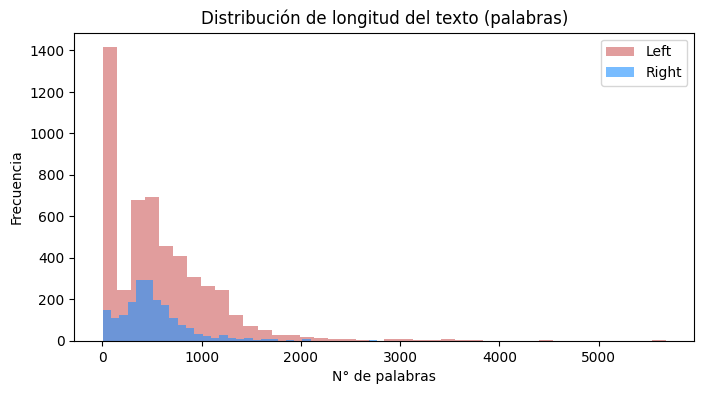

In [142]:
# Histograma de longitudes por clase (visualización simple)
plt.figure(figsize=(8,4))

for cls, color in [("Left", "indianred"), ("Right", "dodgerblue")]:
    subset = df[df["bias_binary"] == cls]["text_len"]
    plt.hist(
        subset,
        bins=40,
        alpha=0.6,
        label=cls,
        color=color
    )

plt.title("Distribución de longitud del texto (palabras)")
plt.xlabel("N° de palabras")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()


### Lectura política del EDA

- La **distribución de clases** (Left/Right) revela un desbalance estructural del corpus: no es solo un problema técnico, también sugiere **densidad diferencial de producción/recopilación** por orientación en el ecosistema mediático representado.
- La **longitud** funciona como proxy de estilo discursivo (desarrollo argumental, contextualización). En secciones posteriores se evalúa si el rendimiento del modelo varía con la densidad textual.


## 8. ETAPA 1 – NLP clásico: limpieza, tokenización, stopwords, lematización

In [143]:
# Limpieza básica (inglés): minúsculas, URLs, solo letras, espacios
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["content_clean"] = df["content"].astype(str).apply(clean_text)
df[["content", "content_clean"]].head()


,content,content_clean
0,Trumpâ€™s executive order ends federal diversi...,trump s executive order ends federal diversity...
1,"As Trump throws immigration into uncertainty, ...",as trump throws immigration into uncertainty p...
2,GOP lawmakers react to Trump's actions Error f...,gop lawmakers react to trump s actions error f...
3,Sweeping Jan. 6 pardons spur mixed reactions E...,sweeping jan pardons spur mixed reactions erro...
4,RFK Jr. reports up to $1.2M in credit card deb...,rfk jr reports up to m in credit card debt m n...


In [144]:
# Tokenización + stopwords
nltk.download("punkt_tab") # Add this line to download the missing resource
stop_words = set(stopwords.words("english"))

def tokenize_remove_stopwords(text: str):
    toks = word_tokenize(text)
    toks = [t for t in toks if t not in stop_words and len(t) > 2]
    return toks

df["tokens"] = df["content_clean"].apply(tokenize_remove_stopwords)
df[["content_clean", "tokens"]].head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,content_clean,tokens
0,trump s executive order ends federal diversity...,"[trump, executive, order, ends, federal, diver..."
1,as trump throws immigration into uncertainty p...,"[trump, throws, immigration, uncertainty, pare..."
2,gop lawmakers react to trump s actions error f...,"[gop, lawmakers, react, trump, actions, error,..."
3,sweeping jan pardons spur mixed reactions erro...,"[sweeping, jan, pardons, spur, mixed, reaction..."
4,rfk jr reports up to m in credit card debt m n...,"[rfk, reports, credit, card, debt, net, worth,..."


In [145]:
# Lematización
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]

df["tokens_lem"] = df["tokens"].apply(lemmatize_tokens)
df[["tokens", "tokens_lem"]].head()


,tokens,tokens_lem
0,"[trump, executive, order, ends, federal, diver...","[trump, executive, order, end, federal, divers..."
1,"[trump, throws, immigration, uncertainty, pare...","[trump, throw, immigration, uncertainty, paren..."
2,"[gop, lawmakers, react, trump, actions, error,...","[gop, lawmaker, react, trump, action, error, f..."
3,"[sweeping, jan, pardons, spur, mixed, reaction...","[sweeping, jan, pardon, spur, mixed, reaction,..."
4,"[rfk, reports, credit, card, debt, net, worth,...","[rfk, report, credit, card, debt, net, worth, ..."


In [146]:
# Reconstrucción del texto final (base para análisis y modelos)
df["final_text"] = df["tokens_lem"].apply(lambda x: " ".join(x))
df["final_text"].head()


,final_text
0,trump executive order end federal diversity eq...
1,trump throw immigration uncertainty parent gra...
2,gop lawmaker react trump action error fetching...
3,sweeping jan pardon spur mixed reaction error ...
4,rfk report credit card debt net worth multimil...


## 9. Vocabulario: palabras más frecuentes y WordCloud (por clase)

In [147]:
# Top palabras por clase (conteo)
def top_words(series_text, n=25):
    all_tokens = " ".join(series_text).split()
    return pd.DataFrame(Counter(all_tokens).most_common(n), columns=["word","count"])

top_left_words = top_words(df[df["bias_binary"]=="Left"]["final_text"], 25)
top_right_words = top_words(df[df["bias_binary"]=="Right"]["final_text"], 25)

top_left_words.head(10), top_right_words.head(10)


(        word  count
 0      trump  26963
 1       said  17270
 2  president   9924
 3      state   7754
 4     people   7533
 5      would   6296
 6       year   6205
 7        one   6166
 8       also   5669
 9        new   5484,
         word  count
 0      trump   6626
 1       said   4562
 2  president   3756
 3      state   2581
 4       news   2220
 5       year   2079
 6        one   2070
 7     people   2028
 8      would   1973
 9       also   1834)

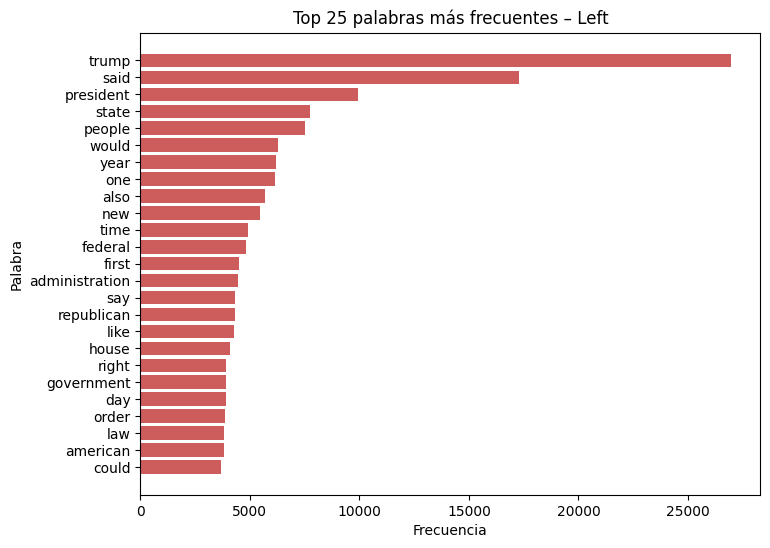

In [148]:
# Top palabras – Left
plt.figure(figsize=(8,6))
plt.barh(
    top_left_words["word"],
    top_left_words["count"],
    color="indianred"
)
plt.title("Top 25 palabras más frecuentes – Left")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.gca().invert_yaxis()
plt.show()


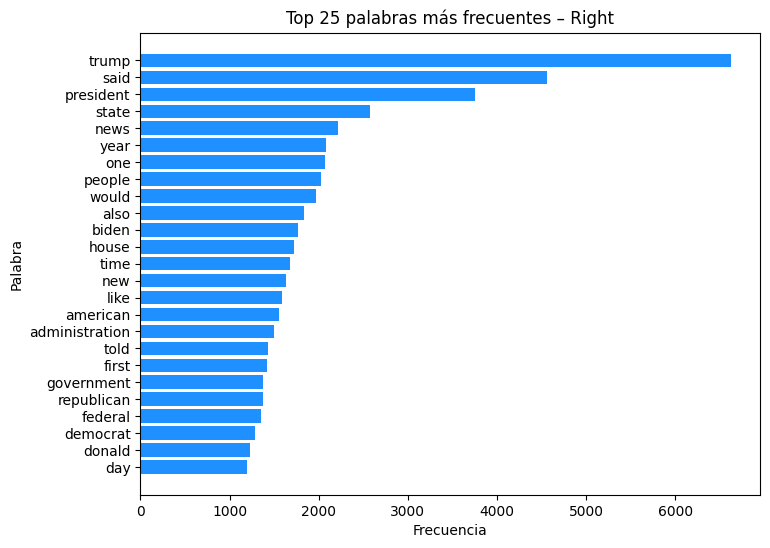

In [149]:
# Top palabras – Right
plt.figure(figsize=(8,6))
plt.barh(
    top_right_words["word"],
    top_right_words["count"],
    color="dodgerblue"
)
plt.title("Top 25 palabras más frecuentes – Right")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.gca().invert_yaxis()
plt.show()

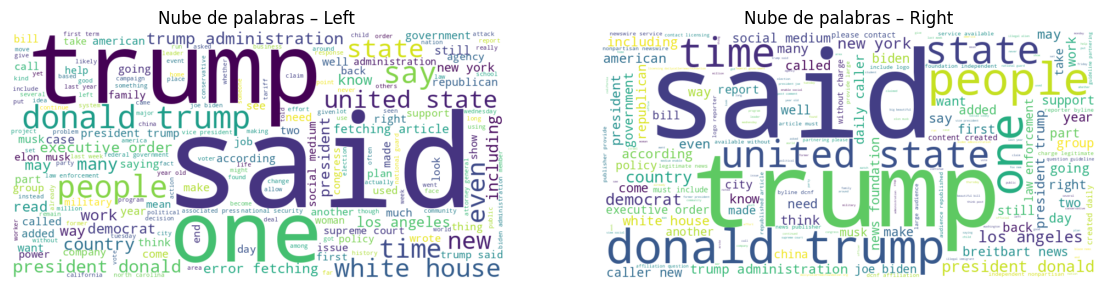

In [150]:
# Nube de palabras
from wordcloud import WordCloud

left_text = " ".join(df[df["bias_binary"]=="Left"]["final_text"])
right_text = " ".join(df[df["bias_binary"]=="Right"]["final_text"])

wc_left = WordCloud(width=900, height=450, background_color="white").generate(left_text)
wc_right = WordCloud(width=900, height=450, background_color="white").generate(right_text)

plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
plt.imshow(wc_left, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras – Left")

plt.subplot(1,2,2)
plt.imshow(wc_right, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras – Right")
plt.show()


### Interpretación del vocabulario

- El vocabulario frecuente y las nubes de palabras no “prueban ideología”, pero sí permiten observar **repertorios léxicos** y **campos temáticos** dominantes.
- La lectura sustantiva se refuerza con n-gramas y co-ocurrencias (marcos), y con NER (actores nombrados).


## 10. N-gramas (bigramas y trigramas)

In [151]:
def top_ngrams_df(texts, ngram_range=(2,2), top_k=20):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=5, max_df=0.9)
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    idx = freqs.argsort()[::-1][:top_k]
    return pd.DataFrame({"ngram": terms[idx], "count": freqs[idx]})

top_left_bi = top_ngrams_df(df[df["bias_binary"]=="Left"]["final_text"], (2,2), 20)
top_right_bi = top_ngrams_df(df[df["bias_binary"]=="Right"]["final_text"], (2,2), 20)

top_left_tri = top_ngrams_df(df[df["bias_binary"]=="Left"]["final_text"], (3,3), 20)
top_right_tri = top_ngrams_df(df[df["bias_binary"]=="Right"]["final_text"], (3,3), 20)

top_left_bi.head(10), top_right_bi.head(10), top_left_tri.head(10), top_right_tri.head(10)


(                  ngram  count
 0          donald trump   3295
 1           white house   2063
 2          united state   1991
 3      president donald   1863
 4  trump administration   1801
 5       executive order   1496
 6           los angeles   1369
 7        error fetching   1302
 8      fetching article   1302
 9              new york   1301,
                   ngram  count
 0          donald trump   1227
 1          united state    789
 2      president donald    749
 3           los angeles    729
 4              new york    672
 5  trump administration    661
 6           white house    613
 7       president trump    598
 8         social medium    500
 9        breitbart news    499,
                     ngram  count
 0  president donald trump   1863
 1  error fetching article   1302
 2     president joe biden    481
 3           new york time    329
 4  president elect donald    258
 5      elect donald trump    258
 6      big beautiful bill    237
 7    vice president v

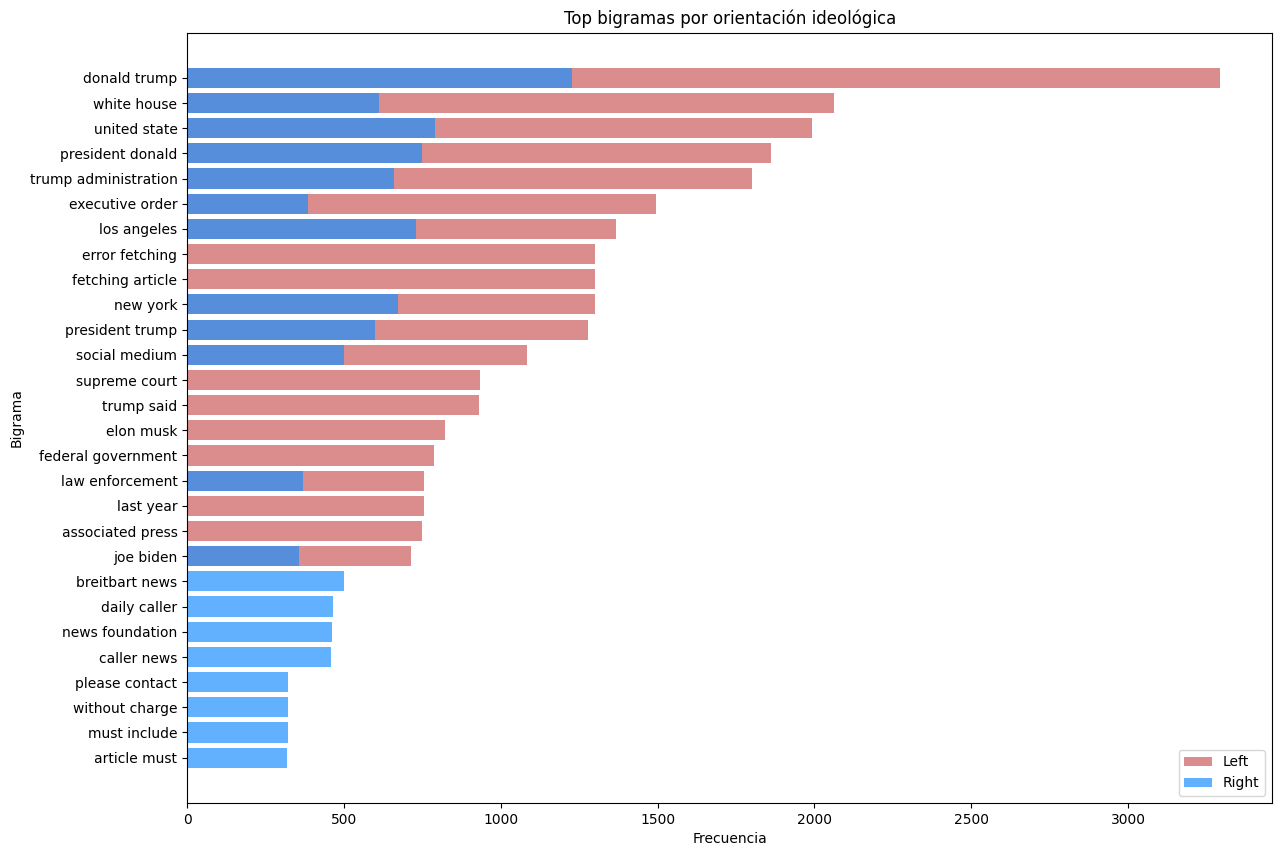

In [152]:
# Bigramas – Left vs Right
plt.figure(figsize=(14,10))

plt.barh(
    top_left_bi["ngram"],
    top_left_bi["count"],
    alpha=0.7,
    label="Left",
    color="indianred"
)

plt.barh(
    top_right_bi["ngram"],
    top_right_bi["count"],
    alpha=0.7,
    label="Right",
    color="dodgerblue"
)

plt.title("Top bigramas por orientación ideológica")
plt.xlabel("Frecuencia")
plt.ylabel("Bigrama")
plt.legend()
plt.gca().invert_yaxis()
plt.show()


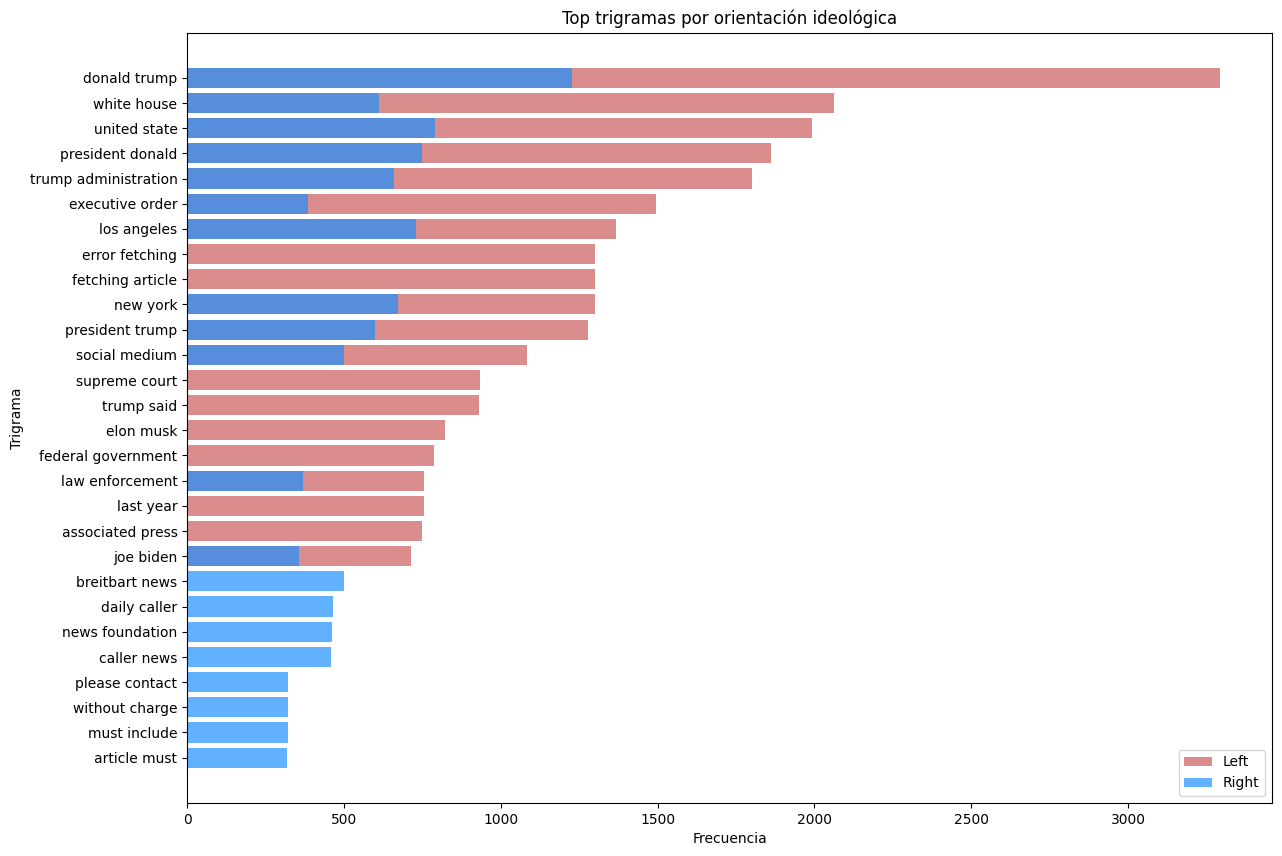

In [153]:
# Trigramas – Left vs Right
plt.figure(figsize=(14,10))

plt.barh(
    top_left_bi["ngram"],
    top_left_bi["count"],
    alpha=0.7,
    label="Left",
    color="indianred"
)

plt.barh(
    top_right_bi["ngram"],
    top_right_bi["count"],
    alpha=0.7,
    label="Right",
    color="dodgerblue"
)

plt.title("Top trigramas por orientación ideológica")
plt.xlabel("Frecuencia")
plt.ylabel("Trigrama")
plt.legend()
plt.gca().invert_yaxis()
plt.show()


### Lectura (n-gramas)

Los bigramas y trigramas se analizan por separado debido a que representan unidades lingüísticas distintas y no son directamente comparables en términos de frecuencia ni función discursiva.  
En la interpretación conviene observar:

- qué actores/temas aparecen como pares estables,
- qué vocabulario se vincula a conflicto/orden vs derechos/políticas públicas,
- qué combinaciones podrían ser “señales” de fuente/estilo (y no solo de ideología).


## 11. Co-ocurrencias: matriz y grafo semántico (edges más gruesas = mayor conexión)

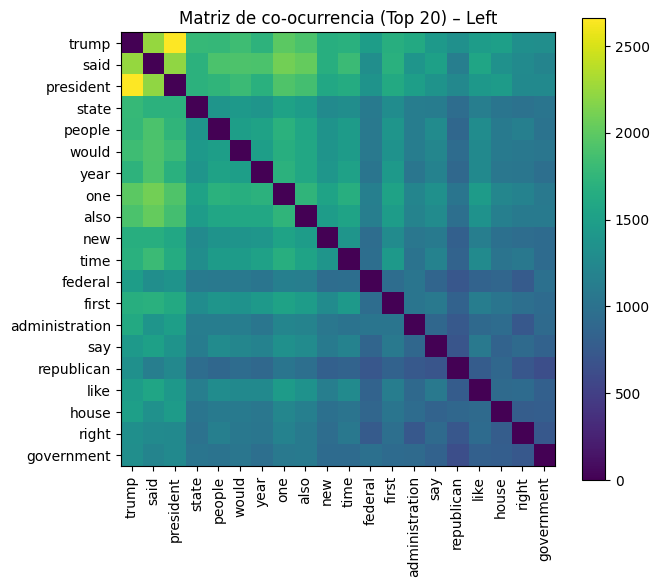

In [154]:
def cooccurrence_matrix(texts, top_n=20):
    tokens = " ".join(texts).split()
    vocab = [w for w,_ in Counter(tokens).most_common(top_n)]
    idx = {w:i for i,w in enumerate(vocab)}
    mat = np.zeros((top_n, top_n), dtype=int)

    for doc in texts:
        ws = [w for w in set(doc.split()) if w in idx]
        for a,b in combinations(ws, 2):
            i,j = idx[a], idx[b]
            mat[i,j] += 1
            mat[j,i] += 1
    return vocab, mat

vocab_left, mat_left = cooccurrence_matrix(df[df["bias_binary"]=="Left"]["final_text"], top_n=20)
plt.figure(figsize=(7,6))
plt.imshow(mat_left)
plt.xticks(range(len(vocab_left)), vocab_left, rotation=90)
plt.yticks(range(len(vocab_left)), vocab_left)
plt.title("Matriz de co-ocurrencia (Top 20) – Left")
plt.colorbar()
plt.show()


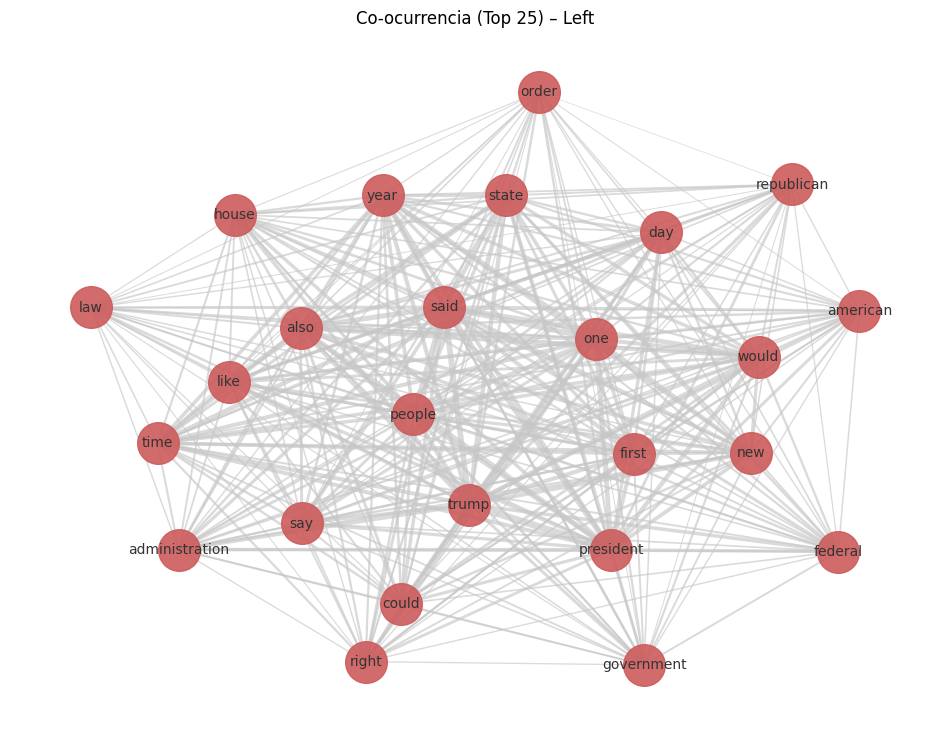

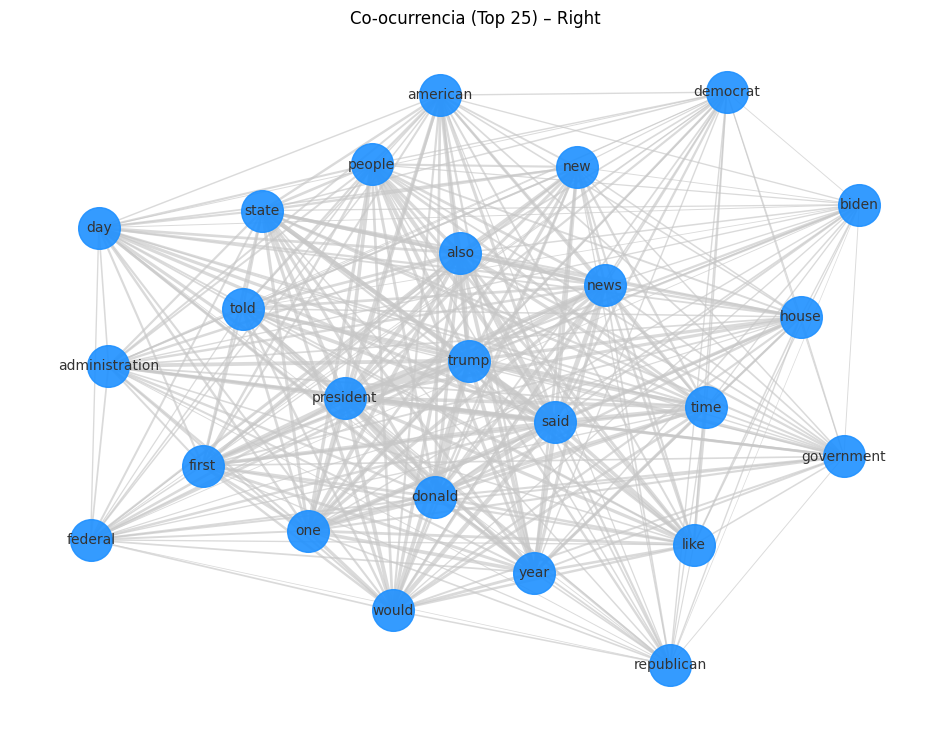

In [155]:
# Grafo de co-ocurrencia (con estilo solicitado: aristas gris claro, nodos con color distinto)
def plot_cooccurrence_network(
    texts,
    top_n=25,
    min_edge=40,
    title="Co-occurrence network",
    node_color="#1f77b4",
    edge_color="#c7c7c7"
):
    all_tokens = " ".join(texts).split()
    vocab = [w for w, _ in Counter(all_tokens).most_common(top_n)]
    vocab_set = set(vocab)

    edge_counts = Counter()
    for doc in texts:
        ws = [w for w in set(doc.split()) if w in vocab_set]
        for a, b in combinations(sorted(ws), 2):
            edge_counts[(a, b)] += 1

    G = nx.Graph()
    for w in vocab:
        G.add_node(w)

    for (a, b), c in edge_counts.items():
        if c >= min_edge:
            G.add_edge(a, b, weight=c)

    if G.number_of_edges() == 0:
        print("No se dibujaron aristas. Baja min_edge o sube top_n.")
        return

    plt.figure(figsize=(12, 9))
    pos = nx.spring_layout(G, k=0.7, seed=42)

    weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
    widths = 0.5 + 4.5 * (weights - weights.min()) / (weights.max() - weights.min() + 1e-9)

    nx.draw_networkx_nodes(G, pos, node_size=900, node_color=node_color, alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=widths, edge_color=edge_color, alpha=0.65)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="#333333")

    plt.title(title)
    plt.axis("off")
    plt.show()

plot_cooccurrence_network(
    df[df["bias_binary"]=="Left"]["final_text"],
    top_n=25,
    min_edge=60,
    title="Co-ocurrencia (Top 25) – Left",
    node_color="indianred",
    edge_color="#c7c7c7"
)

plot_cooccurrence_network(
    df[df["bias_binary"]=="Right"]["final_text"],
    top_n=25,
    min_edge=40,
    title="Co-ocurrencia (Top 25) – Right",
    node_color="dodgerblue",
    edge_color="#c7c7c7"
)


### Interpretación política (co-ocurrencias)

- Las co-ocurrencias muestran **qué conceptos se articulan conjuntamente** (estructura semántica), no solo qué palabras aparecen.
- Los nodos “puente” suelen indicar términos que conectan campos temáticos y pueden revelar **encuadres** recurrentes.
- Diferencias entre grafos Left/Right sugieren divergencias en **organización de problemas** (amenaza/orden vs derechos/políticas, por ejemplo), pero también pueden reflejar **señales de fuente**.


## 12. Análisis gramatical y semántico: POS tagging y NER

In [156]:
# spaCy pipeline
nlp = spacy.load("en_core_web_sm")


In [157]:
# POS counts (muestra para eficiencia)
def pos_counts(texts, n_docs=400, seed=42):
    sample = texts.sample(min(n_docs, len(texts)), random_state=seed)
    counts = Counter()
    for doc in nlp.pipe(sample.tolist(), disable=["ner"]):
        counts.update([t.pos_ for t in doc if t.is_alpha])
    return pd.DataFrame(counts.most_common(), columns=["POS","count"])

pos_left = pos_counts(df[df["bias_binary"]=="Left"]["final_text"])
pos_right = pos_counts(df[df["bias_binary"]=="Right"]["final_text"])

pos_left, pos_right


(      POS  count
 0    NOUN  46642
 1   PROPN  30163
 2    VERB  23724
 3     ADJ  15286
 4     ADV   5192
 5     AUX   1443
 6     NUM   1355
 7     ADP   1340
 8   SCONJ    504
 9    PRON    407
 10    DET    282
 11   INTJ    164
 12      X     89
 13  CCONJ     62
 14  PUNCT      2
 15   PART      1,
       POS  count
 0    NOUN  46460
 1    VERB  23432
 2   PROPN  22689
 3     ADJ  15437
 4     ADV   5220
 5     AUX   1476
 6     NUM   1404
 7     ADP   1341
 8   SCONJ    466
 9    PRON    378
 10    DET    278
 11   INTJ    223
 12  CCONJ     53
 13      X     25
 14   PART      7)

In [158]:
# Seleccionamos Top 10 POS globales para comparar
top_pos = (
    pd.concat([pos_left, pos_right])
    .groupby("POS")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

plot_pos = pd.DataFrame({
    "Left": pos_left.set_index("POS").loc[top_pos]["count"],
    "Right": pos_right.set_index("POS").loc[top_pos]["count"]
}).fillna(0)

plot_pos

,Left,Right
POS,,
NOUN,46642,46460
PROPN,30163,22689
VERB,23724,23432
ADJ,15286,15437
ADV,5192,5220
AUX,1443,1476
NUM,1355,1404
ADP,1340,1341
SCONJ,504,466


<Figure size 1000x600 with 0 Axes>

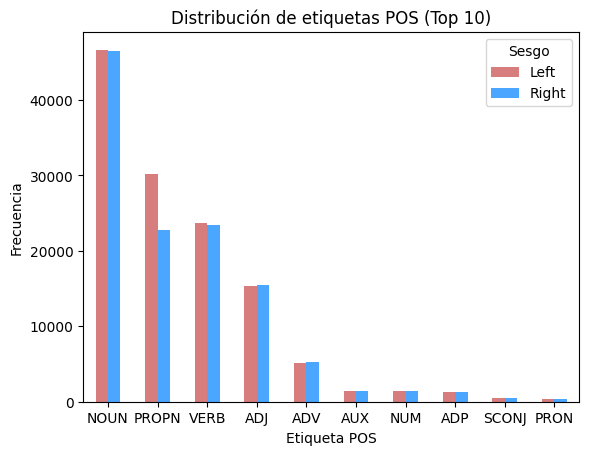

In [159]:
# Gráfico de barras comparativo
plt.figure(figsize=(10,6))

plot_pos.plot(
    kind="bar",
    color=["indianred", "dodgerblue"],
    alpha=0.8
)

plt.title("Distribución de etiquetas POS (Top 10)")
plt.xlabel("Etiqueta POS")
plt.ylabel("Frecuencia")
plt.xticks(rotation=0)
plt.legend(title="Sesgo")
plt.show()


<Figure size 1000x600 with 0 Axes>

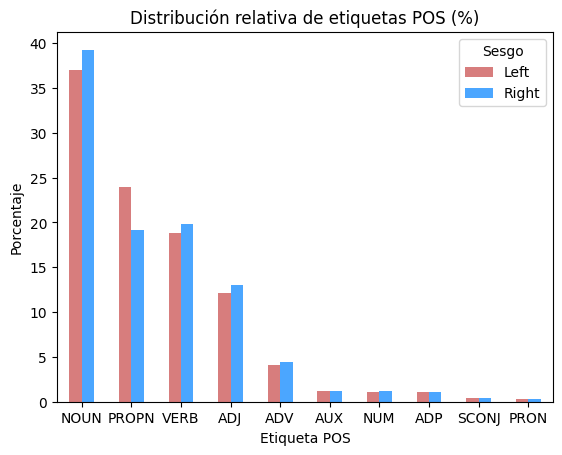

In [160]:
# Normalizar por tamaño del corpus
plot_pos_norm = plot_pos.div(plot_pos.sum(axis=0), axis=1) * 100

plt.figure(figsize=(10,6))
plot_pos_norm.plot(
    kind="bar",
    color=["indianred", "dodgerblue"],
    alpha=0.8
)

plt.title("Distribución relativa de etiquetas POS (%)")
plt.xlabel("Etiqueta POS")
plt.ylabel("Porcentaje")
plt.xticks(rotation=0)
plt.legend(title="Sesgo")
plt.show()


**Interpretación del análisis POS**

La distribución de etiquetas gramaticales permite observar diferencias en el estilo discursivo entre orientaciones ideológicas. Variaciones en la proporción de sustantivos propios, verbos o adjetivos pueden asociarse a distintos énfasis narrativos, como la centralidad de actores e instituciones, la acción política o la evaluación normativa. Este análisis complementa los resultados léxicos y semánticos, aportando una lectura estructural del lenguaje utilizado.

In [161]:
# NER (muestra para eficiencia)
def top_entities(texts, n_docs=400, seed=42, top_k=20):
    sample = texts.sample(min(n_docs, len(texts)), random_state=seed)
    ents = Counter()
    for doc in nlp.pipe(sample.tolist()):
        for ent in doc.ents:
            if ent.label_ in ["PERSON","ORG","GPE","NORP"]:
                ents[(ent.text, ent.label_)] += 1
    out = pd.DataFrame([(k[0], k[1], v) for k,v in ents.most_common(top_k)],
                       columns=["entity","label","count"])
    return out

ner_left = top_entities(df[df["bias_binary"]=="Left"]["final_text"])
ner_right = top_entities(df[df["bias_binary"]=="Right"]["final_text"])

ner_left, ner_right


(          entity   label  count
 0     republican    NORP    301
 1       american    NORP    244
 2   donald trump  PERSON    237
 3       democrat    NORP    197
 4     washington     GPE    144
 5         senate     ORG    114
 6          china     GPE    110
 7       congress     ORG    110
 8    white house     ORG    108
 9            gop     ORG    105
 10    california     GPE    100
 11        israel     GPE     97
 12       florida     GPE     92
 13       america     GPE     85
 14          gaza     GPE     81
 15   palestinian    NORP     81
 16       israeli    NORP     80
 17          fema     ORG     74
 18   los angeles     GPE     71
 19      new york     GPE     68,
           entity   label  count
 0       american    NORP    332
 1     republican    NORP    267
 2       democrat    NORP    250
 3   donald trump  PERSON    243
 4         senate     ORG    136
 5    los angeles     GPE    131
 6     california     GPE    121
 7         israel     GPE    111
 8    whi

In [162]:
# Conteo por tipo de entidad (label)
ner_label_left = ner_left.groupby("label")["count"].sum()
ner_label_right = ner_right.groupby("label")["count"].sum()

ner_labels = pd.DataFrame({
    "Left": ner_label_left,
    "Right": ner_label_right
}).fillna(0)

ner_labels


,Left,Right
label,,
GPE,848,960
NORP,903,849
ORG,511,474
PERSON,237,320


<Figure size 800x500 with 0 Axes>

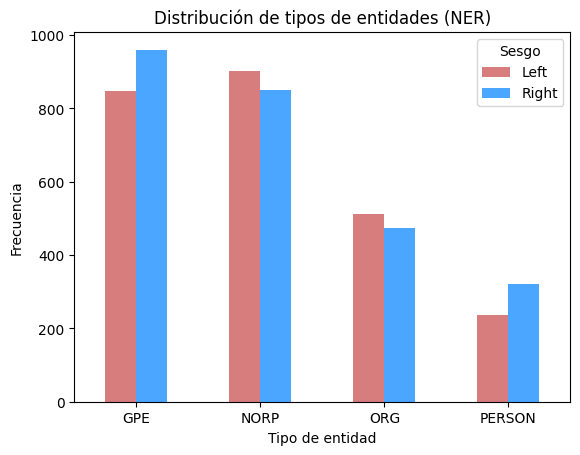

In [163]:
# Gráfico de barras (labels NER)
plt.figure(figsize=(8,5))

ner_labels.plot(
    kind="bar",
    color=["indianred", "dodgerblue"],
    alpha=0.8
)

plt.title("Distribución de tipos de entidades (NER)")
plt.xlabel("Tipo de entidad")
plt.ylabel("Frecuencia")
plt.xticks(rotation=0)
plt.legend(title="Sesgo")
plt.show()


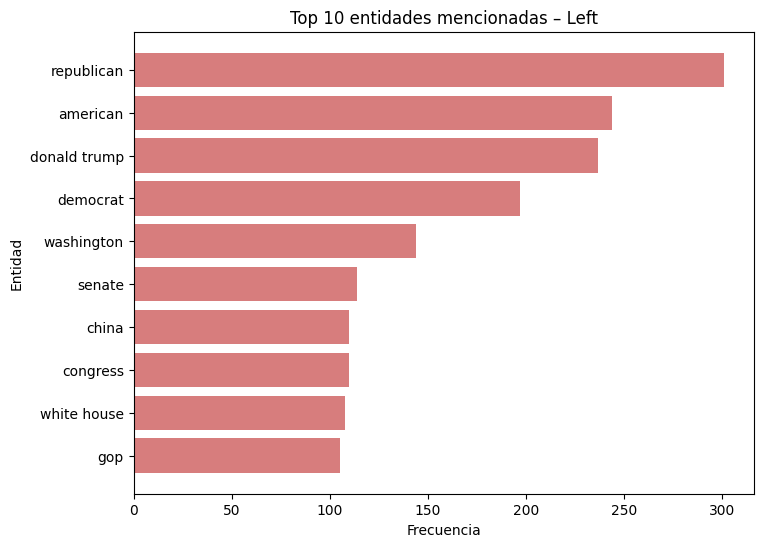

In [164]:
# Entidades más mencionadas (Top 10) Left
plt.figure(figsize=(8,6))
plt.barh(
    ner_left["entity"].head(10),
    ner_left["count"].head(10),
    color="indianred",
    alpha=0.8
)
plt.title("Top 10 entidades mencionadas – Left")
plt.xlabel("Frecuencia")
plt.ylabel("Entidad")
plt.gca().invert_yaxis()
plt.show()


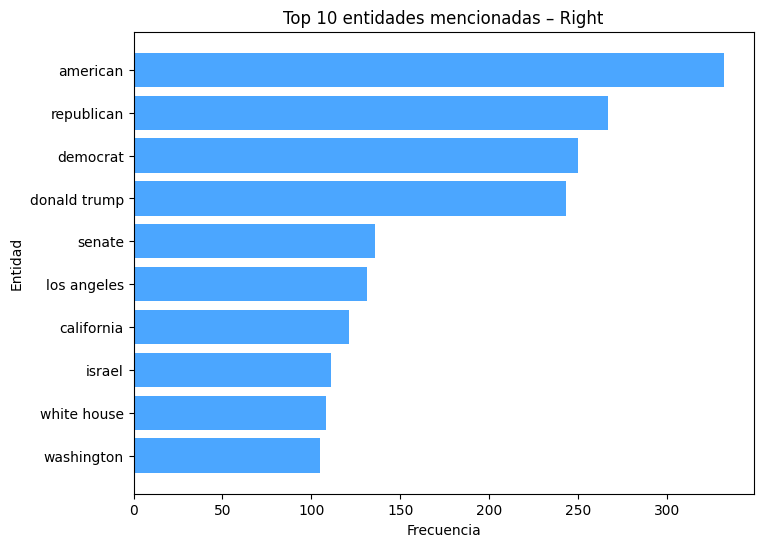

In [165]:
# Entidades más mencionadas (Top 10) Right
plt.figure(figsize=(8,6))
plt.barh(
    ner_right["entity"].head(10),
    ner_right["count"].head(10),
    color="dodgerblue",
    alpha=0.8
)
plt.title("Top 10 entidades mencionadas – Right")
plt.xlabel("Frecuencia")
plt.ylabel("Entidad")
plt.gca().invert_yaxis()
plt.show()

<Figure size 800x500 with 0 Axes>

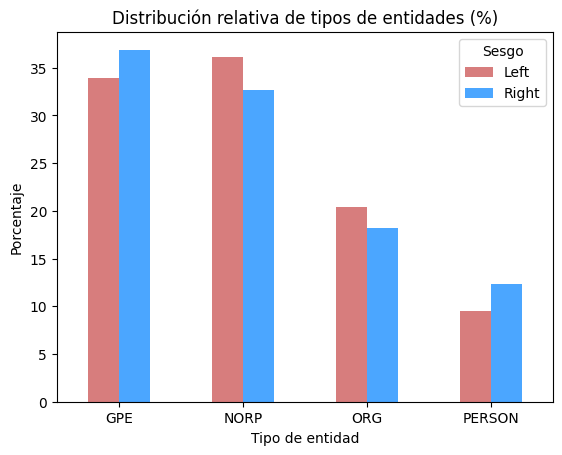

In [166]:
# Normalizar por clase
ner_labels_norm = ner_labels.div(ner_labels.sum(axis=0), axis=1) * 100

plt.figure(figsize=(8,5))
ner_labels_norm.plot(
    kind="bar",
    color=["indianred", "dodgerblue"],
    alpha=0.8
)

plt.title("Distribución relativa de tipos de entidades (%)")
plt.xlabel("Tipo de entidad")
plt.ylabel("Porcentaje")
plt.xticks(rotation=0)
plt.legend(title="Sesgo")
plt.show()

**Interpretación del análisis de entidades nombradas (NER)**

La distribución de tipos de entidades revela diferencias en los focos discursivos de cada orientación ideológica. Mientras una mayor presencia de PERSON sugiere centralidad de liderazgos y actores individuales, la frecuencia de ORG y GPE indica énfasis en instituciones y territorios. Estos patrones refuerzan la idea de que el sesgo político se expresa también en quiénes y qué son nombrados, y no solo en el tono o el contenido temático del texto.

## 13. Análisis de sentimiento (VADER)

In [167]:
sia = SentimentIntensityAnalyzer()
df["sentiment_compound"] = df["final_text"].apply(lambda t: sia.polarity_scores(t)["compound"])

df.groupby("bias_binary")["sentiment_compound"].describe().round(3)


,count,mean,std,min,25%,50%,75%,max
bias_binary,,,,,,,,
Left,5109.0,-0.087,0.805,-1.0,-0.906,-0.402,0.936,1.0
Right,1931.0,-0.007,0.872,-1.0,-0.961,-0.052,0.953,1.0


/tmp/ipython-input-1221123268.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Left","Right"])


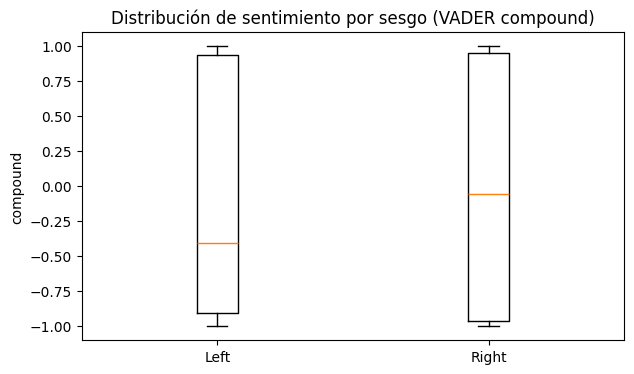

In [168]:
# Boxplot (matplotlib)
plt.figure(figsize=(7,4))
data = [df[df["bias_binary"]=="Left"]["sentiment_compound"], df[df["bias_binary"]=="Right"]["sentiment_compound"]]
plt.boxplot(data, labels=["Left","Right"])
plt.title("Distribución de sentimiento por sesgo (VADER compound)")
plt.ylabel("compound")
plt.show()


Si las diferencias de sentimiento son moderadas, eso sugiere que el sesgo no opera principalmente como “más negatividad/positividad”, sino como **encuadre**: selección de temas, causalidades, actores y soluciones.


In [169]:
# Extraer palabras y scores VADER
sia = SentimentIntensityAnalyzer()

def sentiment_words(series_text, top_n=20):
    tokens = " ".join(series_text).split()
    scores = {w: sia.polarity_scores(w)["compound"] for w in set(tokens)}

    df_scores = (
        pd.DataFrame(scores.items(), columns=["word","compound"])
        .dropna()
    )

    positive = df_scores[df_scores["compound"] > 0.3].sort_values("compound", ascending=False).head(top_n)
    negative = df_scores[df_scores["compound"] < -0.3].sort_values("compound").head(top_n)
    neutral  = df_scores[(df_scores["compound"] >= -0.05) & (df_scores["compound"] <= 0.05)].head(top_n)

    return positive, negative, neutral

pos_left, neg_left, neu_left = sentiment_words(
    df[df["bias_binary"]=="Left"]["final_text"]
)

pos_right, neg_right, neu_right = sentiment_words(
    df[df["bias_binary"]=="Right"]["final_text"]
)

print("--- Palabras de Sentimiento (Sesgo Izquierdo) ---")
print("Palabras Positivas:")
display(pos_left)
print("Palabras Negativas:")
display(neg_left)
print("Palabras Neutrales:")
display(neu_left)

print("\n--- Palabras de Sentimiento (Sesgo Derecho) ---")
print("Palabras Positivas:")
display(pos_right)
print("Palabras Negativas:")
display(neg_right)
print("Palabras Neutrales:")
display(neu_right)


--- Palabras de Sentimiento (Sesgo Izquierdo) ---
Palabras Positivas:


,word,compound
25308,sweetheart,0.6486
17044,greatest,0.6369
20857,lovingly,0.6369
40758,best,0.6369
27987,freedom,0.6369
11405,glorious,0.6369
986,happiest,0.6369
38410,glee,0.6369
7287,paradise,0.6369
3467,perfectly,0.6369


Palabras Negativas:


,word,compound
22220,rapist,-0.7096
38988,raping,-0.7003
27928,slavery,-0.7003
3471,rape,-0.6908
10241,terrorist,-0.6908
1122,murder,-0.6908
12234,kill,-0.6908
2900,terrorism,-0.6808
13951,hell,-0.6808
2853,raped,-0.6808


Palabras Neutrales:


,word,compound
0,nypd,0.0
1,discharged,0.0
2,cruzaban,0.0
3,peacehealth,0.0
4,aumentos,0.0
5,prometedora,0.0
6,xinis,0.0
7,lytton,0.0
8,enarbolaban,0.0
9,bix,0.0



--- Palabras de Sentimiento (Sesgo Derecho) ---
Palabras Positivas:


,word,compound
12288,sweetheart,0.6486
19874,best,0.6369
8270,greatest,0.6369
1707,perfectly,0.6369
3557,paradise,0.6369
10194,lovingly,0.6369
16199,love,0.6369
13569,freedom,0.6369
5541,glorious,0.6369
3228,great,0.6249


Palabras Negativas:


,word,compound
10844,rapist,-0.7096
13539,slavery,-0.7003
18976,raping,-0.7003
1709,rape,-0.6908
5970,kill,-0.6908
4986,terrorist,-0.6908
568,murder,-0.6908
13105,murderer,-0.6808
6790,hell,-0.6808
1435,terrorism,-0.6808


Palabras Neutrales:


,word,compound
0,nypd,0.0
1,discharged,0.0
2,sha,0.0
3,immature,0.0
4,presentencing,0.0
6,curtail,0.0
7,baltimore,0.0
8,plotted,0.0
10,wsmv,0.0
12,teresa,0.0


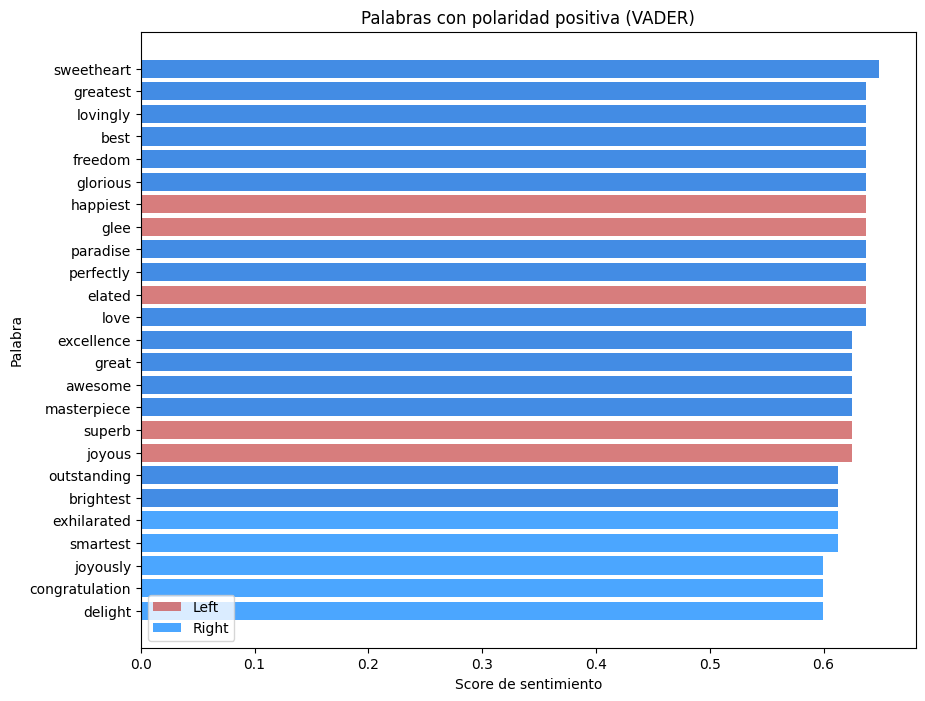

In [170]:
# Palabras positivas más frecuentes
plt.figure(figsize=(10,8))
plt.barh(pos_left["word"], pos_left["compound"], color="indianred", alpha=0.8, label="Left")
plt.barh(pos_right["word"], pos_right["compound"], color="dodgerblue", alpha=0.8, label="Right")
plt.title("Palabras con polaridad positiva (VADER)")
plt.xlabel("Score de sentimiento")
plt.ylabel("Palabra")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

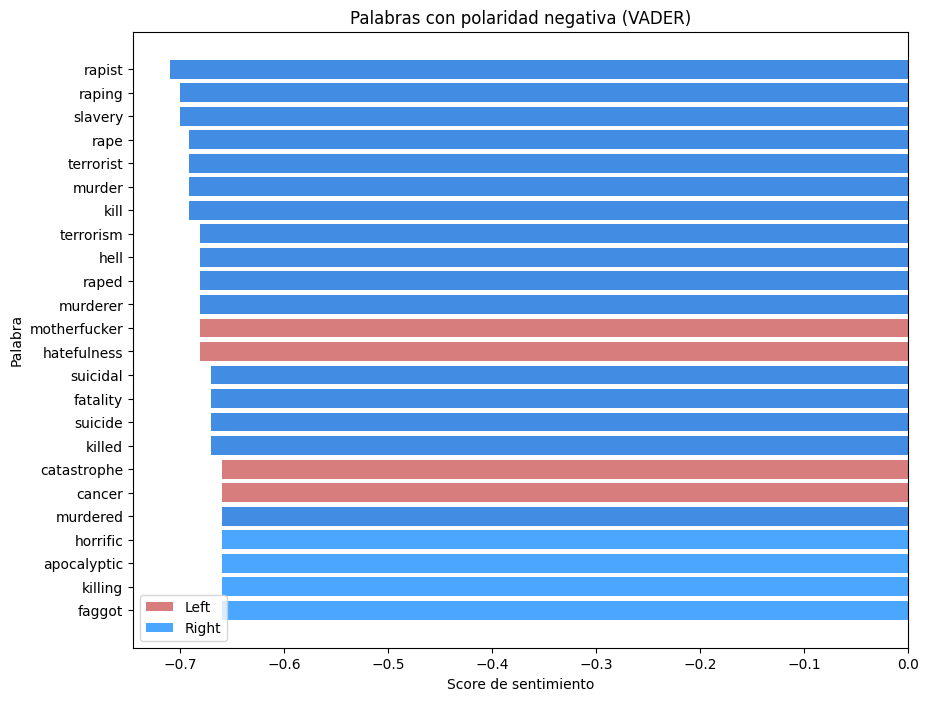

In [171]:
# Palabras negativas más frecuentes
plt.figure(figsize=(10,8))
plt.barh(neg_left["word"], neg_left["compound"], color="indianred", alpha=0.8, label="Left")
plt.barh(neg_right["word"], neg_right["compound"], color="dodgerblue", alpha=0.8, label="Right")
plt.title("Palabras con polaridad negativa (VADER)")
plt.xlabel("Score de sentimiento")
plt.ylabel("Palabra")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

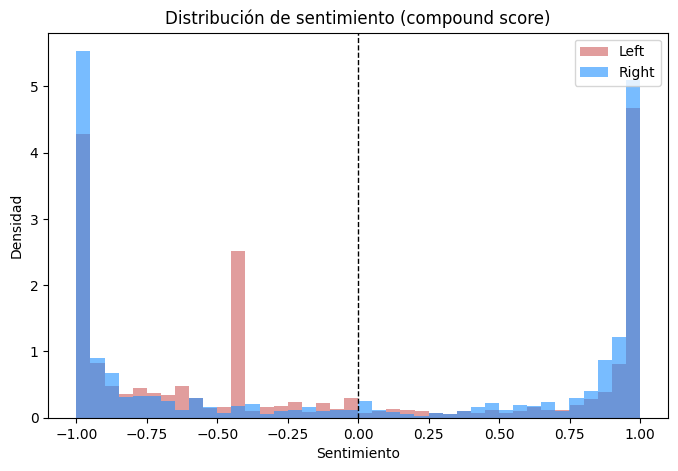

In [172]:
# Distribución general de scores por clase
def sentiment_distribution(series_text):
    scores = []
    for text in series_text:
        scores.append(sia.polarity_scores(text)["compound"])
    return scores

sent_left = sentiment_distribution(df[df["bias_binary"]=="Left"]["final_text"])
sent_right = sentiment_distribution(df[df["bias_binary"]=="Right"]["final_text"])

plt.figure(figsize=(8,5))
plt.hist(sent_left, bins=40, alpha=0.6, color="indianred", label="Left", density=True)
plt.hist(sent_right, bins=40, alpha=0.6, color="dodgerblue", label="Right", density=True)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Distribución de sentimiento (compound score)")
plt.xlabel("Sentimiento")
plt.ylabel("Densidad")
plt.legend()
plt.show()


### Análisis de sentimiento

El análisis de sentimiento muestra que las diferencias entre orientaciones ideológicas no se explican
principalmente por contrastes emocionales extremos. Tanto en textos clasificados como Left como Right,
la distribución del puntaje compuesto se concentra en valores cercanos a la neutralidad, con una ligera
asimetría según la orientación.

El examen del vocabulario asociado a polaridad positiva y negativa sugiere que el sentimiento opera de
manera contextual y estratégica. Las palabras evaluadas como negativas suelen vincularse a conflictos,
crisis o actores adversarios, mientras que las positivas aparecen asociadas a logros, valores normativos
o identidades propias. Esto refuerza la idea de que el sesgo político no se construye principalmente a
través del tono emocional, sino mediante la selección de temas, actores y encuadres narrativos.

Desde una perspectiva política, estos resultados indican que el lenguaje periodístico tiende a mantener
una apariencia de neutralidad emocional, incluso cuando reproduce marcos ideológicos diferenciados. El
sesgo, por lo tanto, se manifiesta más como una estructura semántica que como una retórica emocional
explícita.


## 14. ETAPA 2 – Modelos supervisados (BoW y TF-IDF)

In [173]:
# Train/test split (estratificado)
X = df["final_text"].astype(str)
y = df["bias_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test)


(5632, 1408)

=== BoW + Logistic Regression ===
              precision    recall  f1-score   support

        Left       0.95      0.94      0.94      1022
       Right       0.84      0.86      0.85       386

    accuracy                           0.92      1408
   macro avg       0.89      0.90      0.90      1408
weighted avg       0.92      0.92      0.92      1408



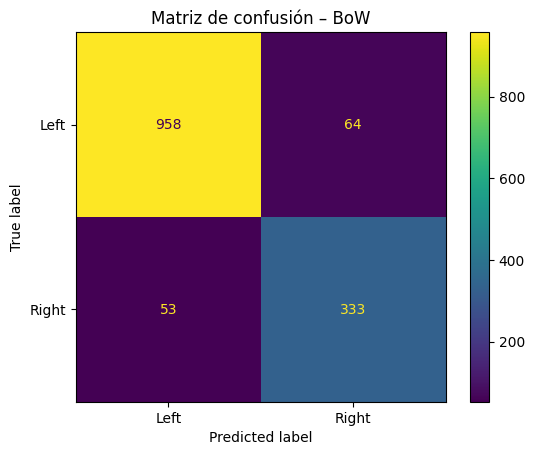

In [174]:
# Baseline BoW + Regresión Logística
bow = CountVectorizer(min_df=5, max_df=0.9)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

clf_bow = LogisticRegression(max_iter=1000, class_weight="balanced")
clf_bow.fit(X_train_bow, y_train)
y_pred_bow = clf_bow.predict(X_test_bow)

print("=== BoW + Logistic Regression ===")
print(classification_report(y_test, y_pred_bow))
cm_bow = confusion_matrix(y_test, y_pred_bow, labels=["Left","Right"])
ConfusionMatrixDisplay(cm_bow, display_labels=["Left","Right"]).plot()
plt.title("Matriz de confusión – BoW")
plt.show()


=== TF-IDF + Logistic Regression ===
              precision    recall  f1-score   support

        Left       0.96      0.96      0.96      1022
       Right       0.89      0.89      0.89       386

    accuracy                           0.94      1408
   macro avg       0.92      0.92      0.92      1408
weighted avg       0.94      0.94      0.94      1408



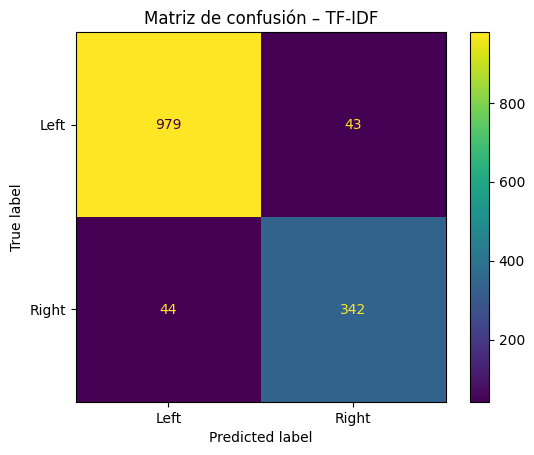

In [175]:
# TF-IDF + Regresión Logística (modelo principal)
tfidf = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

print("=== TF-IDF + Logistic Regression ===")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=["Left","Right"])
ConfusionMatrixDisplay(cm, display_labels=["Left","Right"]).plot()
plt.title("Matriz de confusión – TF-IDF")
plt.show()


## 15. Interpretación del modelo: términos discriminantes, longitud y fuentes

In [176]:
# Top términos discriminantes (coeficientes)
feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_[0]

top_left = pd.DataFrame({
    "term": feature_names[np.argsort(coefs)[:10]],
    "coef": np.sort(coefs)[:10]
})
top_right = pd.DataFrame({
    "term": feature_names[np.argsort(coefs)[-10:][::-1]],
    "coef": np.sort(coefs)[-10:][::-1]
})

top_left, top_right


(               term      coef
 0             trump -5.404695
 1              read -4.174230
 2  fetching article -3.293847
 3    error fetching -3.293847
 4          fetching -3.293847
 5              said -3.101676
 6             error -3.092140
 7               que -2.179228
 8     advertisement -2.112659
 9        republican -2.104351,
              term      coef
 0       breitbart  4.281479
 1  breitbart news  3.564923
 2      think post  3.288382
 3    post comment  3.264895
 4    read article  3.027284
 5         illegal  2.826867
 6           think  2.716942
 7            riot  2.329146
 8           biden  2.307551
 9            news  2.252421)

In [177]:
# Rendimiento por cuartiles de longitud
df_test = df.loc[X_test.index].copy()
df_test["y_true"] = y_test.values
df_test["y_pred"] = y_pred
df_test["len_quartile"] = pd.qcut(df_test["text_len"], 4, labels=["Q1_short","Q2","Q3","Q4_long"])

acc_by_len = df_test.groupby("len_quartile").apply(lambda x: (x["y_true"] == x["y_pred"]).mean())
acc_by_len


/tmp/ipython-input-1439239732.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_len = df_test.groupby("len_quartile").apply(lambda x: (x["y_true"] == x["y_pred"]).mean())
/tmp/ipython-input-1439239732.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_len = df_test.groupby("len_quartile").apply(lambda x: (x["y_true"] == x["y_pred"]).mean())


,0
len_quartile,
Q1_short,0.937677
Q2,0.911681
Q3,0.946023
Q4_long,0.957386


In [178]:
# Distribución ideológica por fuente (top 10 fuentes por volumen)
top_sources = df["Source"].value_counts().head(10).index
source_bias = (
    df[df["Source"].isin(top_sources)]
    .groupby(["Source","bias_binary"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
)
source_bias.round(3)


,bias_binary,Left,Right
Source,Source,,
Alternet,Alternet,1.0,NaN
Apnews,Apnews,1.0,NaN
BreitBart,BreitBart,NaN,1.0
Huffpost,Huffpost,1.0,NaN
IndependentJournalReview,IndependentJournalReview,NaN,1.0
NewYorkPost,NewYorkPost,NaN,1.0
TheFreePress,TheFreePress,NaN,1.0
abcnews,abcnews,1.0,NaN
npr,npr,1.0,NaN


### Lectura del modelo

- **Términos discriminantes:** muestran qué repertorios léxicos y señales de ecosistema empujan al modelo hacia Left/Right.
- **Longitud:** si el rendimiento sube con textos largos, es consistente con la hipótesis de que el sesgo aparece más claro en desarrollos argumentales (no solo en titulares).
- **Fuentes:** patrones fuertes por `Source` sugieren segmentación mediática. Esto es políticamente relevante, pero también indica un riesgo: parte de la predicción puede estar capturando “señales de medio” además de ideología.


## 16. Modelo de Deep Learning (MLP con Keras/TensorFlow)

### Modelo de Deep Learning (MLP)

Como baseline de Deep Learning se implementa una red neuronal multicapa (MLP) utilizando Keras/TensorFlow.
Se opta por una arquitectura relativamente simple debido al tamaño del dataset y al objetivo exploratorio
del modelo.

- Se utilizan capas densas (Dense) para capturar combinaciones no lineales de los rasgos textuales.
- Se incorpora Dropout como técnica de regularización, con el fin de reducir el sobreajuste, especialmente
  relevante en contextos de alta dimensionalidad como los vectores TF-IDF.
- La función de activación ReLU permite modelar relaciones no lineales, mientras que la capa de salida
  utiliza activación sigmoide para resolver un problema de clasificación binaria (Left vs Right).

Este modelo no busca maximizar el rendimiento predictivo absoluto, sino complementar los enfoques
lineales y ofrecer un punto de comparación metodológico.


In [179]:
# Preparación para DL (Right=1, Left=0)
X_dl = df["final_text"].astype(str).values
y_dl = (df["bias_binary"] == "Right").astype(int).values

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl
)

max_words = 20000
max_len = 300

tok = Tokenizer(num_words=max_words, oov_token="<OOV>")
tok.fit_on_texts(X_train_dl)

train_seq = tok.texts_to_sequences(X_train_dl)
test_seq  = tok.texts_to_sequences(X_test_dl)

X_train_pad = pad_sequences(train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad  = pad_sequences(test_seq,  maxlen=max_len, padding="post", truncating="post")

model = tf.keras.Sequential([
    layers.Embedding(max_words, 64, input_length=max_len),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [180]:
history = model.fit(
    X_train_pad, y_train_dl,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    verbose=1
)


Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7160 - loss: 0.6221 - val_accuracy: 0.7311 - val_loss: 0.5639
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7299 - loss: 0.5470 - val_accuracy: 0.7311 - val_loss: 0.5243
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7420 - loss: 0.4791 - val_accuracy: 0.8012 - val_loss: 0.4365
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8610 - loss: 0.3600 - val_accuracy: 0.8527 - val_loss: 0.3511
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9159 - loss: 0.2512 - val_accuracy: 0.8749 - val_loss: 0.3024


In [181]:
# Evaluación DL
from sklearn.metrics import classification_report

y_prob = model.predict(X_test_pad).ravel()
y_pred_dl = (y_prob >= 0.5).astype(int)

print("=== MLP (Keras) ===")
print(classification_report(y_test_dl, y_pred_dl, target_names=["Left","Right"]))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
=== MLP (Keras) ===
              precision    recall  f1-score   support

        Left       0.88      0.97      0.92      1022
       Right       0.88      0.66      0.75       386

    accuracy                           0.88      1408
   macro avg       0.88      0.81      0.84      1408
weighted avg       0.88      0.88      0.88      1408



### Lectura DL vs ML

El MLP sirve como baseline de Deep Learning. Puede mejorar o no respecto a TF-IDF+LR.  
Desde una perspectiva analítica, el punto central es comparar:

- **Interpretabilidad:** LR ofrece términos discriminantes explícitos; DL es más opaco.
- **Rendimiento:** si DL no supera a LR, esto es consistente con corpora donde señales léxicas y de fuente son fuertes.


### Matriz de Confusión comparativa

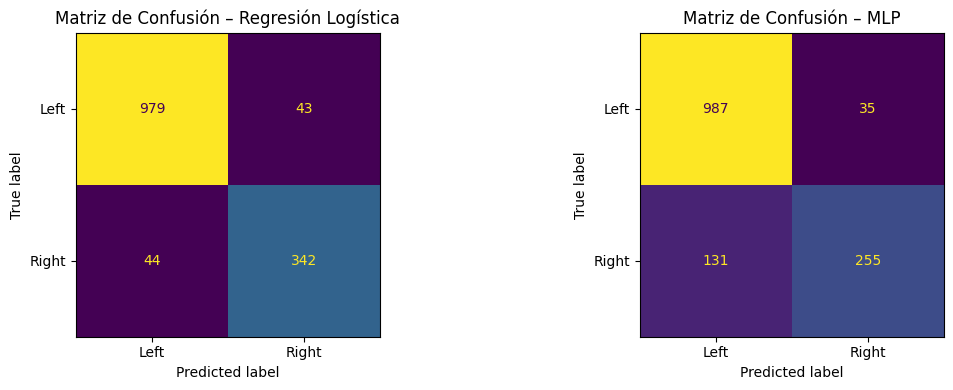

In [182]:
# Matriz de Confusión comparativa
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Regresión Logística
cm_lr = confusion_matrix(y_test, y_pred)
disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=["Left","Right"])
disp_lr.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de Confusión – Regresión Logística")

# MLP
cm_mlp = confusion_matrix(y_test_dl, y_pred_dl)
disp_mlp = ConfusionMatrixDisplay(cm_mlp, display_labels=["Left","Right"])
disp_mlp.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de Confusión – MLP")

plt.tight_layout()
plt.show()

La comparación visual de las matrices de confusión permite observar cómo cada modelo maneja los errores
de clasificación entre orientaciones ideológicas. Mientras la Regresión Logística muestra un comportamiento
más estable y simétrico, el MLP presenta variaciones que pueden asociarse a la sensibilidad del modelo
frente al desbalance de clases y la complejidad no lineal de los datos.


## 17. Conclusiones

Los resultados del proyecto confirman que el sesgo político en textos periodísticos es empíricamente detectable a partir de patrones lingüísticos y semánticos relativamente estables. A través del análisis exploratorio y del entrenamiento de modelos supervisados, se observa que las orientaciones ideológicas no se manifiestan únicamente en opiniones explícitas, sino en regularidades más profundas del discurso, tales como la selección del vocabulario, la forma en que los términos se organizan semánticamente y los actores e instituciones que son recurrentemente nombrados.

En particular, los modelos entrenados —tanto los enfoques lineales basados en TF-IDF como el baseline de Deep Learning— aprenden combinaciones de rasgos asociadas a marcos discursivos diferenciados. Los análisis de co-ocurrencia, n-gramas, POS y NER muestran que el sesgo se expresa como un sistema de encuadre: qué problemas se conectan entre sí, qué actores adquieren centralidad y qué dimensiones del conflicto político son priorizadas. Este hallazgo resulta políticamente relevante, ya que sugiere que la ideología opera menos como una cuestión de tono emocional y más como una estructura narrativa que organiza la interpretación de la realidad política.

Desde esta perspectiva, el aporte principal del trabajo no reside únicamente en la capacidad predictiva de los modelos, sino en su potencial analítico. El uso combinado de visualizaciones lingüísticas y modelos de clasificación permite avanzar hacia una comprensión más fina del sesgo mediático, entendiendo a los textos periodísticos como productos discursivos situados en ecosistemas políticos y comunicacionales específicos.

No obstante, estos resultados deben interpretarse teniendo en cuenta una serie de limitaciones metodológicas, que se detallan a continuación.

### Limitaciones del estudio

Además del desbalance de clases presente en el dataset, es importante señalar otras limitaciones
relevantes. En primer lugar, los textos analizados se encuentran en idioma inglés y corresponden
principalmente al contexto político estadounidense, lo que limita la generalización directa de los
resultados a otros países o sistemas mediáticos.

En segundo lugar, el corpus no controla explícitamente por dimensión temporal. Cambios en el contexto
político, coyunturas electorales o eventos críticos pueden influir en el vocabulario y los marcos
discursivos, introduciendo un sesgo temporal que los modelos no distinguen de manera explícita.

Estas limitaciones refuerzan la necesidad de interpretar los resultados como patrones situados,
más que como propiedades universales del sesgo político.


---

## 18. Perspectivas futuras

- Extender el pipeline al análisis de **discursos políticos y redes sociales**, donde el sesgo puede ser más implícito y estratégico.
- Modelar el sesgo en forma **ordinal** (Left → Lean Left → Center → Lean Right → Right) en lugar de binaria.
- Incorporar **embeddings contextuales** (e.g., Sentence-BERT) y comparar interpretabilidad vs rendimiento.

---

En conjunto, el proyecto demuestra cómo las herramientas de NLP y aprendizaje automático pueden ser
utilizadas no solo para clasificar textos, sino también para explorar críticamente las dimensiones
lingüísticas y semánticas a través de las cuales se construye el sesgo político en los medios. De este modo,
la ciencia de datos se presenta no solo como una herramienta predictiva, sino también como un recurso
analítico para el estudio empírico de fenómenos políticos complejos.